In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
from keras import layers
from keras import models
from sklearn.metrics import mean_absolute_error, mean_squared_error

1. Load and Review the Dataset

In [4]:
# import pandas as pd

# Load the train and test datasets
train_df = pd.read_csv('../data/train.csv')

# Display the first few rows of the train dataset
print("First few rows of the train dataset:")
print(train_df.head())

# Display summary statistics of the train dataset
print("\nSummary statistics of the train dataset:")
print(train_df.describe())

# List the column names of the train dataset
print("\nColumn names of the train dataset:")
print(train_df.columns.tolist())

# Display the first few rows of the test dataset
#print("\nFirst few rows of the test dataset:")
#print(test_df.head())

# Display summary statistics of the test dataset
print("\nSummary statistics of the test dataset:")
#print(test_df.describe())

# List the column names of the test dataset
print("\nColumn names of the test dataset:")
#print(test_df.columns.tolist())


First few rows of the train dataset:
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0         120       FV            0     3830   Pave  Pave      IR1   
1         120       FV            0     4217   Pave  Pave      IR1   
2         120       FV            0     4538   Pave   NaN      IR1   
3         120       FV            0     4765   Pave   NaN      IR1   
4         120       FV           25     4835   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub   CulDSac  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      1    20

2. Basic Statistical Analysis

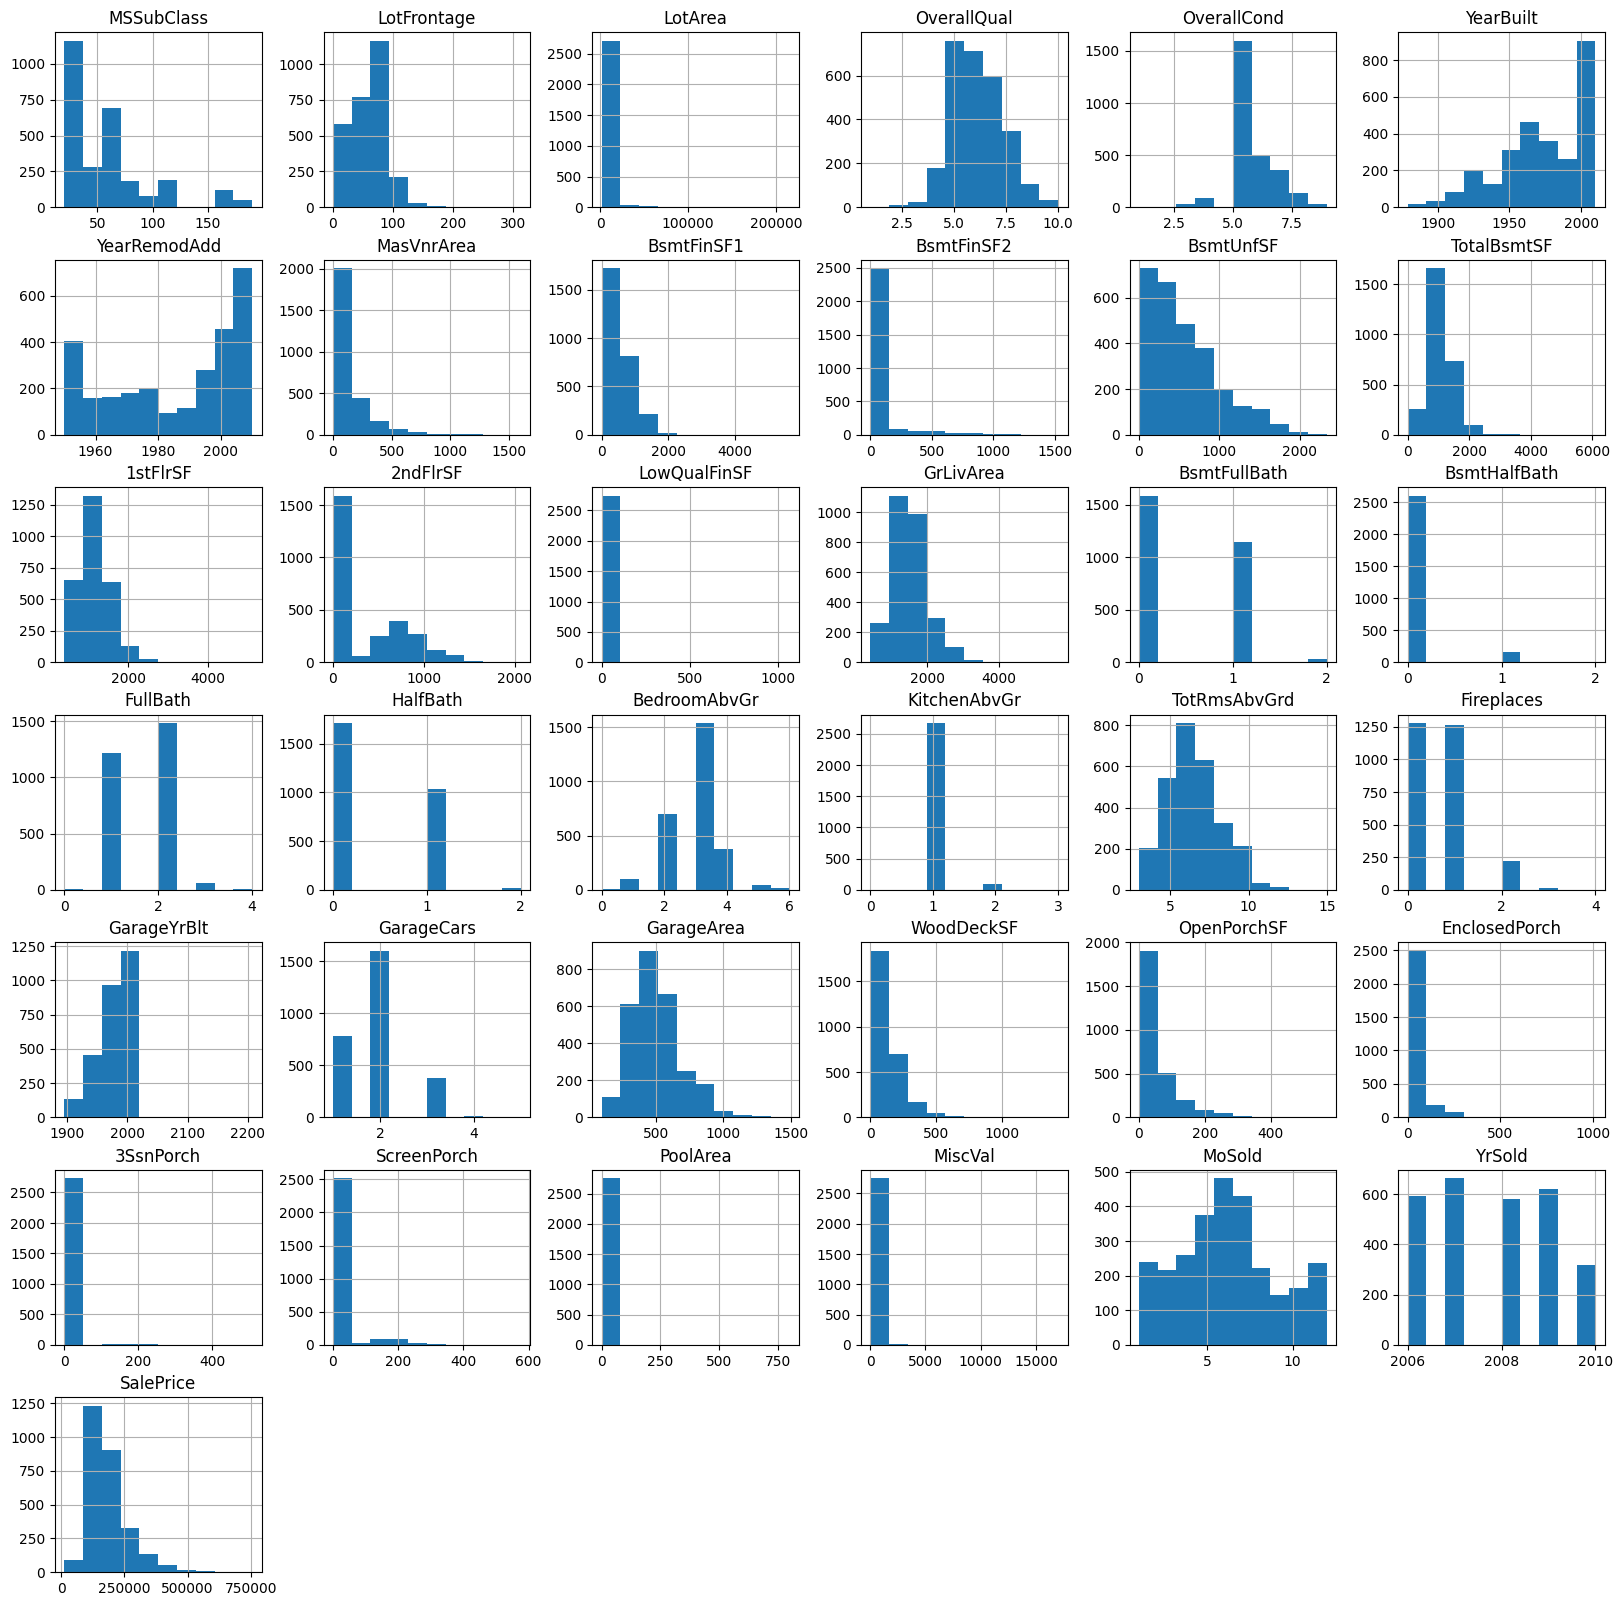

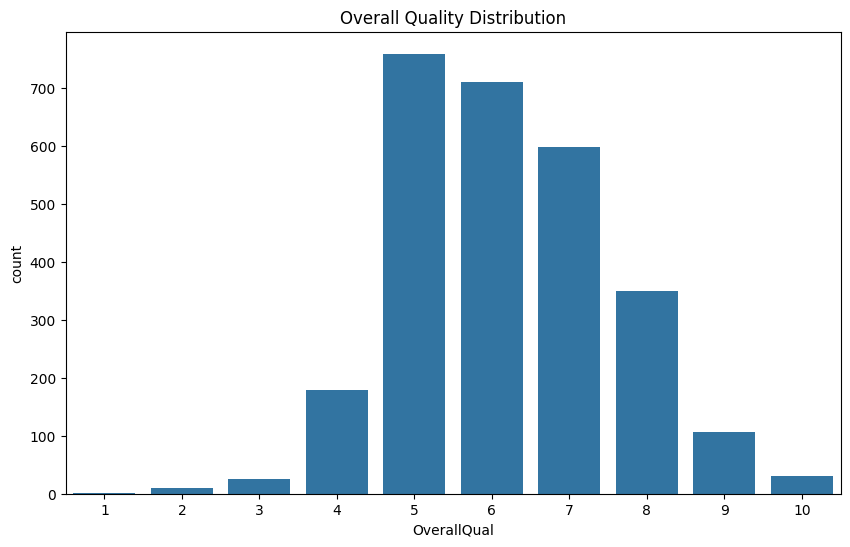

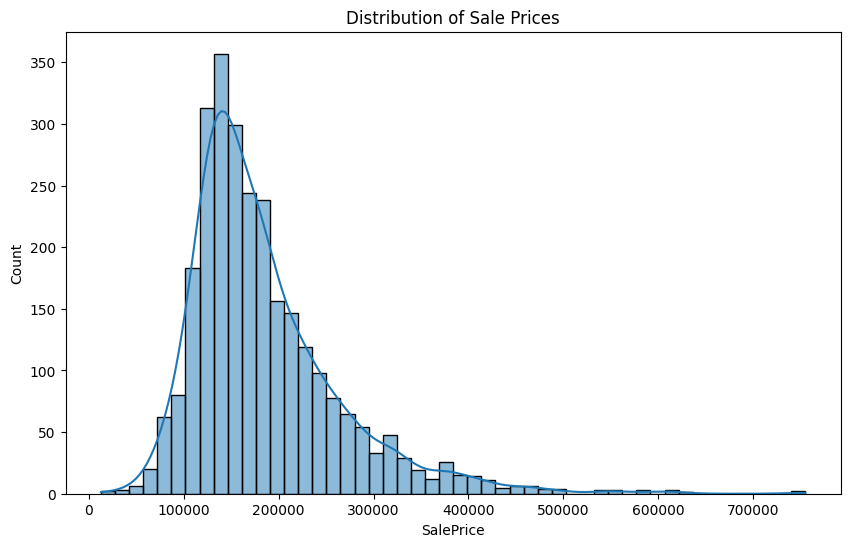

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for key features
train_df.hist(figsize=(20, 20))     # create histograms for all numerical features in the dataset
plt.show()                          # display the plots

# Bar plot of overall quality
plt.figure(figsize=(10, 6))                     # set the figure size
sns.countplot(x='OverallQual', data=train_df)   # create a count plot for the OverallQual column
plt.title('Overall Quality Distribution')       # add a title to the plot
plt.show()                                    # display the plot

# Distribution of sale prices
plt.figure(figsize=(10, 6))                     # set the figure size
sns.histplot(train_df['SalePrice'], bins=50, kde=True)  # create a histogram with a kernel density estimate for the SalePrice column
plt.title('Distribution of Sale Prices')                # add a title to the plot
plt.show()                                              # display the plot


3. Feature Analysis

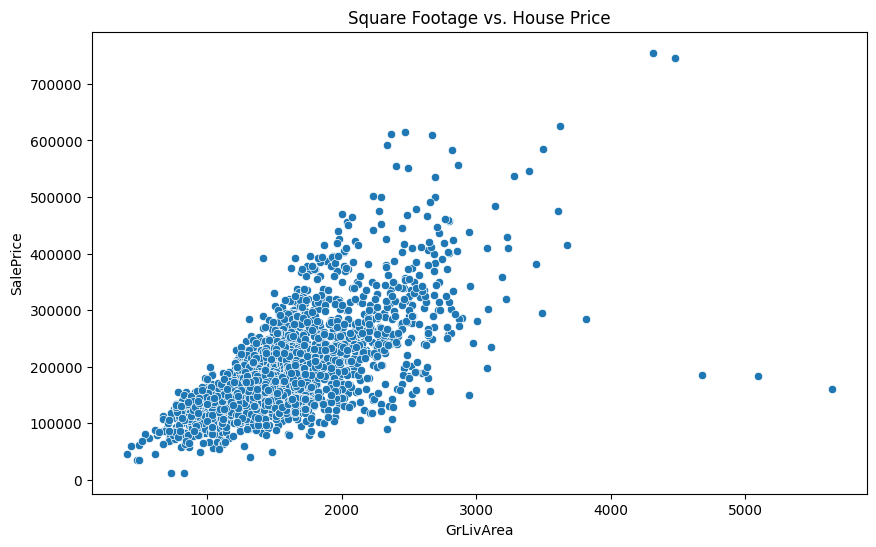

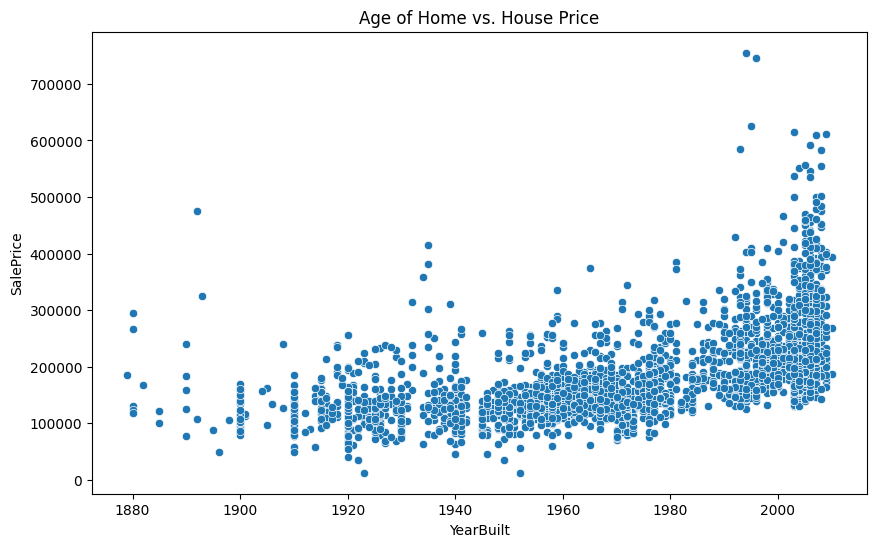

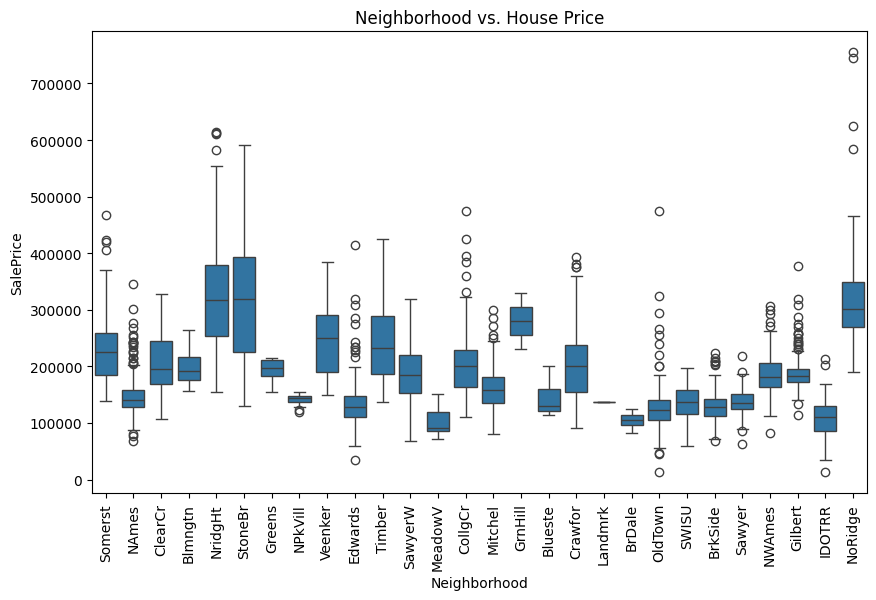

In [6]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Scatter plot of square footage vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)  # Create a scatter plot for square footage (GrLivArea) vs. house price (SalePrice)
plt.title('Square Footage vs. House Price')  # Add a title to the plot
plt.show()  # Display the plot

# Scatter plot of age of home vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_df)  # Create a scatter plot for the age of home (YearBuilt) vs. house price (SalePrice)
plt.title('Age of Home vs. House Price')  # Add a title to the plot
plt.show()  # Display the plot

# Scatter plot of neighborhood vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)  # Create a box plot for neighborhood (Neighborhood) vs. house price (SalePrice)
plt.title('Neighborhood vs. House Price')  # Add a title to the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot


4. Data Processing and Feature Engineering 

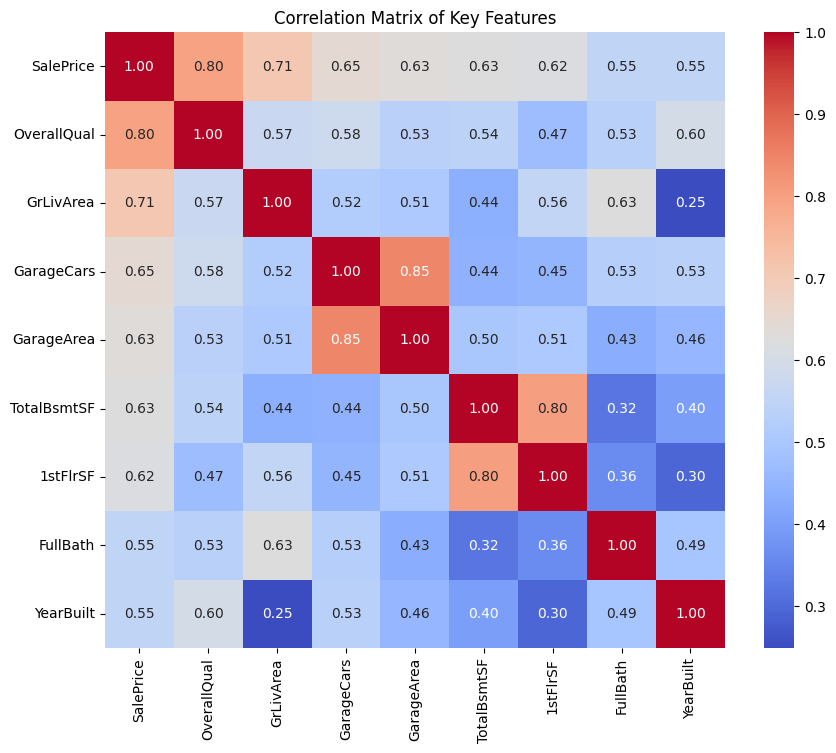

In [7]:
# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Select key features for correlation analysis
key_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

# Filter the correlation matrix for the key features
key_correlation_matrix = correlation_matrix.loc[key_features, key_features]

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(key_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()


Random Forest Regressor Performance:
Mean Absolute Error (MAE): 16966.26381123981
Mean Squared Error (MSE): 858646978.5041244


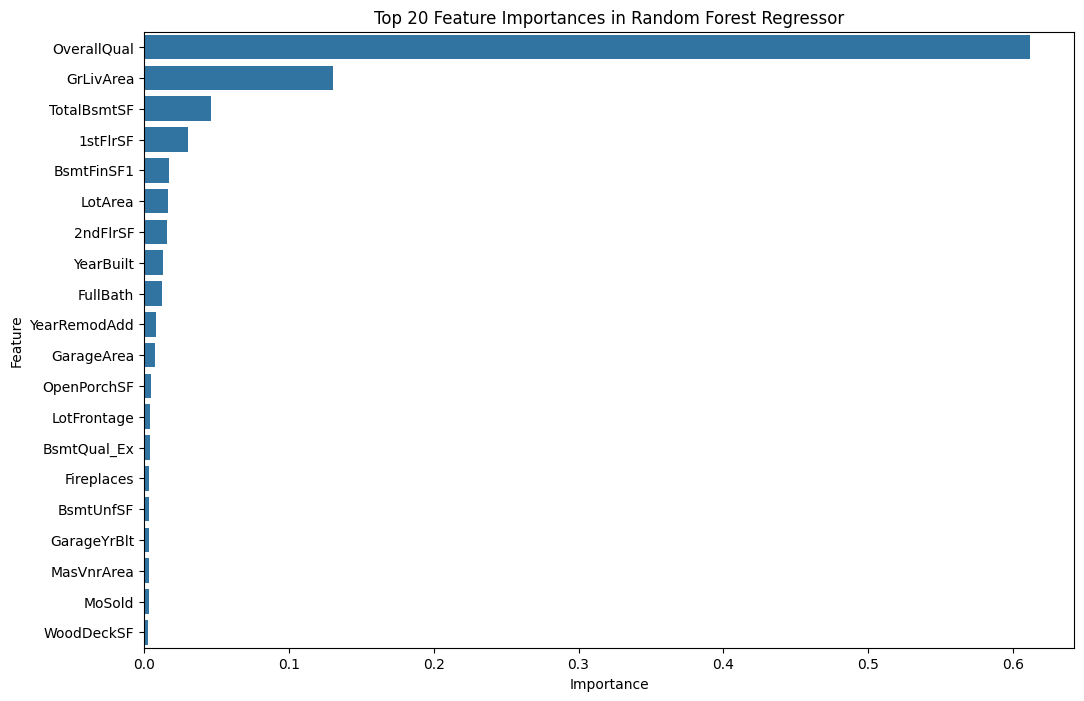

In [8]:
# Separate the target variable and features
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Define preprocessing for numerical data (impute missing values and scale)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data (impute missing values and one-hot encode)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display the results
print("Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate feature importance
feature_importances = rf_model.feature_importances_

# Get feature names
onehot_features = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols))
all_features = num_cols + onehot_features

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Top 20 Feature Importances in Random Forest Regressor')
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Random Forest Regressor Performance:
Mean Absolute Error (MAE): 16549.095591326466
Mean Squared Error (MSE): 794798495.8807358
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


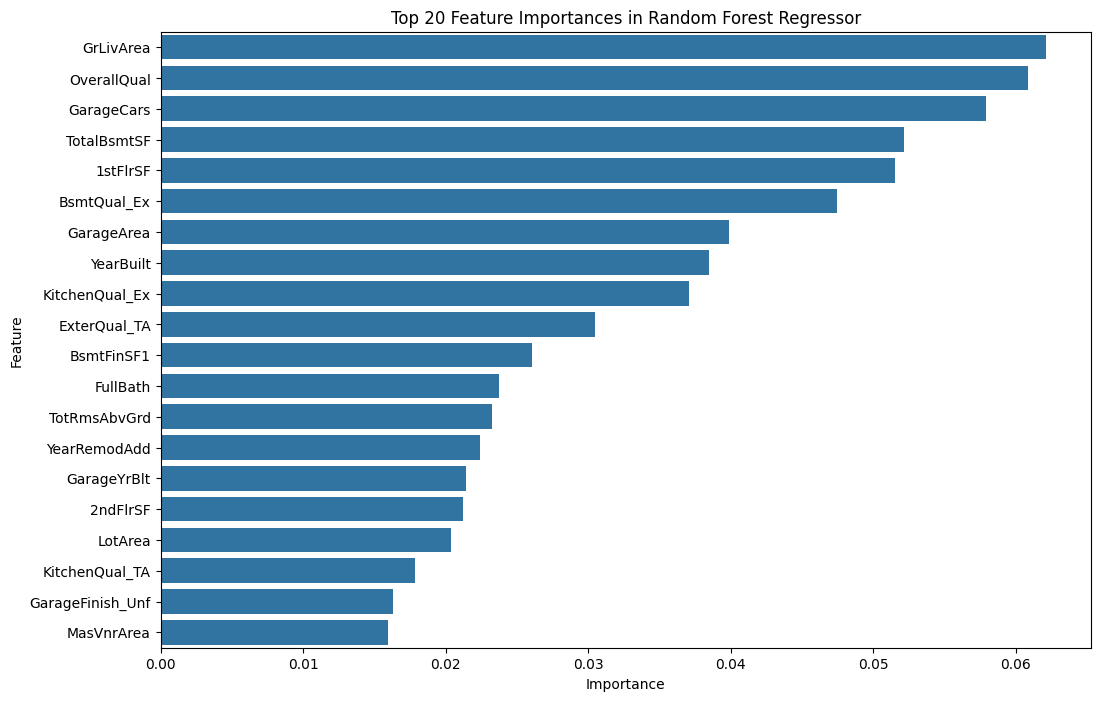

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Define a more efficient parameter grid for quicker optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Define the RandomizedSearchCV with fewer iterations
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid,
                               n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_

# Train the final model with the best parameters
rf_optimized = RandomForestRegressor(**best_params)
rf_optimized.fit(X_train, y_train)

# Make predictions
y_pred_optimized = rf_optimized.predict(X_test)

# Evaluate the model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

# Display the results
print("Optimized Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_optimized}")
print(f"Mean Squared Error (MSE): {mse_optimized}")
print(f"Best Parameters: {best_params}")

# Evaluate feature importance
feature_importances = rf_optimized.feature_importances_

# Get feature names
onehot_features = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols))
all_features = num_cols + onehot_features

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Top 20 Feature Importances in Random Forest Regressor')
plt.show()
